# Air Quality Time Series Prediction with Sliding Windows

This notebook implements **Linear Regression with Sliding Windows** for time series forecasting of PM 2.5 air quality.

## Key Concepts:
- **Sliding Windows**: Creating features from past time steps to predict future values
- **Time Series Forecasting**: Using historical data to predict future PM 2.5 levels
- **Linear Regression**: Applied on windowed features for prediction


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Load and Explore the Data


In [21]:
# Load the dataset
df = pd.read_csv('Real_Combine.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset Shape: (1000, 8)

First few rows:


,T,TM,Tm,H,VV,V,VM,PM 2.5
0,19.9,27.0,12.0,55.0,4.7,8.7,24.1,255.875000
1,21.3,29.0,15.0,45.0,4.5,6.7,14.8,217.083333
2,21.2,29.5,14.0,40.0,4.0,5.4,14.8,229.166667
3,17.3,24.0,11.0,34.0,5.1,11.7,64.4,298.458333
4,18.2,25.0,10.0,43.0,4.8,6.1,14.8,264.916667


In [22]:
# Check for missing values and data info
print("Missing Values:")
print(df.isnull().sum())
print("\nData Info:")
df.info()


Missing Values:
T         0
TM        0
Tm        0
H         0
VV        0
V         0
VM        0
PM 2.5    5
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1000 non-null   float64
 1   TM      1000 non-null   float64
 2   Tm      1000 non-null   float64
 3   H       1000 non-null   float64
 4   VV      1000 non-null   float64
 5   V       1000 non-null   float64
 6   VM      1000 non-null   float64
 7   PM 2.5  995 non-null    float64
dtypes: float64(8)
memory usage: 62.6 KB


In [23]:
# Handle missing values
df = df.dropna()
print(f"Data shape after dropping missing values: {df.shape}")

# Reset index to ensure proper time series ordering
df = df.reset_index(drop=True)


Data shape after dropping missing values: (995, 8)


## 2. Time Series Visualization


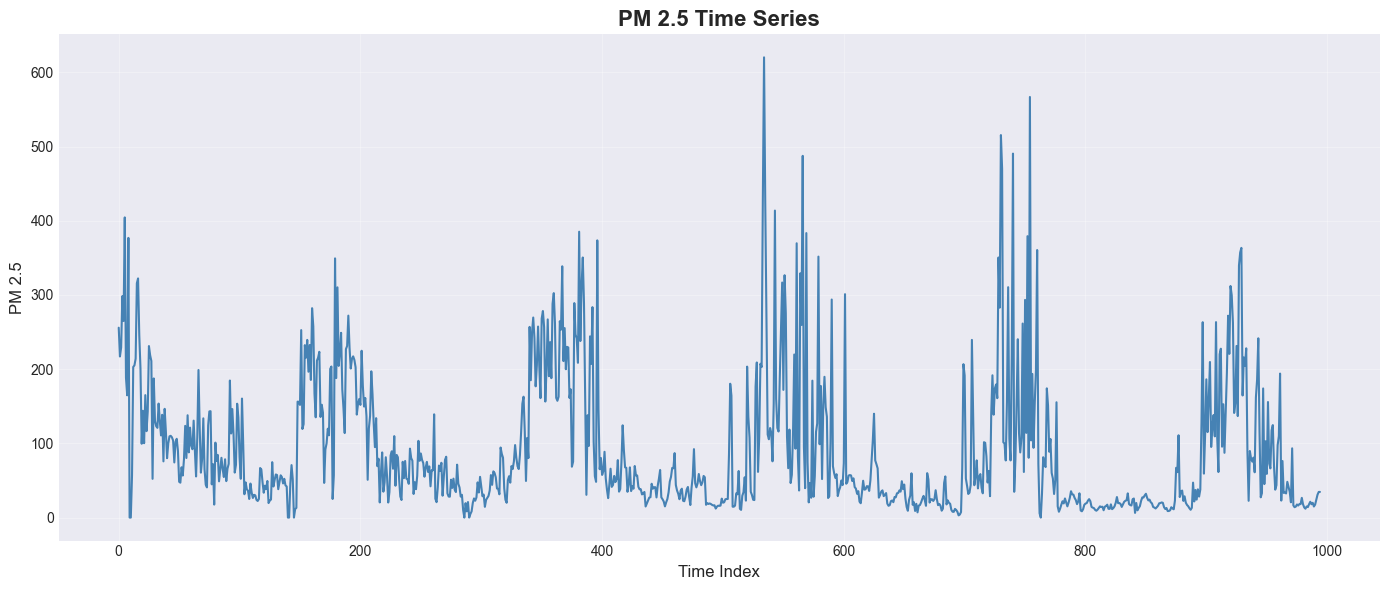

In [24]:
# Visualize the PM 2.5 time series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['PM 2.5'], linewidth=1.5, color='steelblue')
plt.title('PM 2.5 Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('PM 2.5', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Sliding Window Function

The sliding window approach creates features from past time steps to predict future values.


In [25]:
def create_sliding_windows(data, window_size, forecast_horizon=1):
    """
    Create sliding windows for time series prediction.
    
    Parameters:
    -----------
    data : array-like
        Time series data (can be 1D for univariate or 2D for multivariate)
    window_size : int
        Number of past time steps to use as features
    forecast_horizon : int
        Number of steps ahead to predict (default=1)
    
    Returns:
    --------
    X : numpy array
        Features matrix with shape (samples, window_size * features)
    y : numpy array
        Target values with shape (samples, forecast_horizon)
    """
    X, y = [], []
    
    # Handle both univariate and multivariate cases
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    n_samples = len(data)
    
    # Create sliding windows
    for i in range(window_size, n_samples - forecast_horizon + 1):
        # Features: past window_size time steps
        X.append(data[i-window_size:i].flatten())
        # Target: future forecast_horizon time steps
        y.append(data[i:i+forecast_horizon, -1])  # Assuming last column is target
    
    return np.array(X), np.array(y)

print("Sliding window function created successfully!")


Sliding window function created successfully!


## 4. Prepare Data for Sliding Windows

We'll use both the weather features and PM 2.5 values to create features.


In [26]:
# Extract features and target
feature_cols = ['T', 'TM', 'Tm', 'H', 'VV', 'V', 'VM', 'PM 2.5']
data = df[feature_cols].values

print(f"Data shape: {data.shape}")
print(f"Features used: {feature_cols}")


Data shape: (995, 8)
Features used: ['T', 'TM', 'Tm', 'H', 'VV', 'V', 'VM', 'PM 2.5']


## 5. Create Sliding Windows

We'll experiment with different window sizes to find the optimal one.


In [27]:
# Define window size (number of past time steps to use)
# You can experiment with different window sizes: 3, 5, 7, 10, etc.
window_size = 5  # Using 5 past time steps
forecast_horizon = 1  # Predicting 1 step ahead

# Create sliding windows
X, y = create_sliding_windows(data, window_size=window_size, forecast_horizon=forecast_horizon)

print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"\nEach sample uses {window_size} past time steps with {len(feature_cols)} features each")
print(f"Total features per sample: {X.shape[1]}")


Features shape (X): (990, 40)
Target shape (y): (990, 1)

Each sample uses 5 past time steps with 8 features each
Total features per sample: 40


In [28]:
# Visualize how sliding windows work
print("Example of sliding window structure:")
print(f"\nFirst sample features (X[0]):")
print(f"Shape: {X[0].shape}")
print(f"Values: {X[0]}")
print(f"\nFirst sample target (y[0]):")
print(f"Shape: {y[0].shape}")
print(f"Value: {y[0]}")

print(f"\nThis means:")
print(f"- We use data from time steps 0 to {window_size-1} to predict time step {window_size}")
print(f"- We use data from time steps 1 to {window_size} to predict time step {window_size+1}")
print(f"- And so on...")


Example of sliding window structure:

First sample features (X[0]):
Shape: (40,)
Values: [ 19.9         27.          12.          55.           4.7
   8.7         24.1        255.875       21.3         29.
  15.          45.           4.5          6.7         14.8
 217.08333333  21.2         29.5         14.          40.
   4.           5.4         14.8        229.16666667  17.3
  24.          11.          34.           5.1         11.7
  64.4        298.45833333  18.2         25.          10.
  43.           4.8          6.1         14.8        264.91666667]

First sample target (y[0]):
Shape: (1,)
Value: [404.5]

This means:
- We use data from time steps 0 to 4 to predict time step 5
- We use data from time steps 1 to 5 to predict time step 6
- And so on...


## 6. Train-Test Split for Time Series

**Important**: For time series, we must use chronological split (not random) to preserve temporal order.


In [29]:
# Time series split: use first 80% for training, last 20% for testing
# IMPORTANT: Both train and test sets use sliding windows!
# - X_train contains windowed features from the first 80% of the time series
# - X_test contains windowed features from the last 20% of the time series
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training set: {X_train.shape[0]} samples (each with {window_size} past time steps)")
print(f"Test set: {X_test.shape[0]} samples (each with {window_size} past time steps)")
print(f"\nTraining period: windowed samples 0 to {split_index-1}")
print(f"Test period: windowed samples {split_index} to {len(X)-1}")
print(f"\n✓ Both training and testing use sliding windows with window_size={window_size}")


Training set: 792 samples (each with 5 past time steps)
Test set: 198 samples (each with 5 past time steps)

Training period: windowed samples 0 to 791
Test period: windowed samples 792 to 989

✓ Both training and testing use sliding windows with window_size=5


## 7. Train Linear Regression Model


In [30]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"Number of coefficients: {len(model.coef_)}")
# Handle intercept (it can be a scalar or array depending on y shape)
intercept_value = float(np.atleast_1d(model.intercept_)[0])
print(f"Intercept: {intercept_value:.4f}")


Model trained successfully!
Number of coefficients: 1
Intercept: 197.9709


## 8. Make Predictions


In [31]:
# Make predictions on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Flatten if needed (for forecast_horizon > 1)
if y_train.ndim > 1 and y_train.shape[1] == 1:
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    y_train_pred = y_train_pred.flatten()
    y_test_pred = y_test_pred.flatten()

print("Predictions completed!")


Predictions completed!


## 9. Model Evaluation


## 9.5. Residual Diagnostic Plots

**Checking the Four Key Assumptions of Linear Regression:**

1. **Linearity**: The relationship between predictors and response is linear
2. **Independence**: Residuals are independent (especially important for time series)
3. **Homoscedasticity**: Constant variance of residuals across all fitted values
4. **Normality**: Residuals are normally distributed


In [32]:
# Calculate residuals for both train and test sets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred
y_train_fitted = y_train_pred
y_test_fitted = y_test_pred

# Combine for overall analysis (or analyze separately)
all_residuals = np.concatenate([train_residuals, test_residuals])
all_fitted = np.concatenate([y_train_fitted, y_test_fitted])
all_order = np.arange(len(all_residuals))

print("Residuals calculated for diagnostic analysis")
print(f"Train residuals: mean={np.mean(train_residuals):.4f}, std={np.std(train_residuals):.4f}")
print(f"Test residuals: mean={np.mean(test_residuals):.4f}, std={np.std(test_residuals):.4f}")


Residuals calculated for diagnostic analysis
Train residuals: mean=0.0000, std=63.3555
Test residuals: mean=-11.3654, std=48.6133


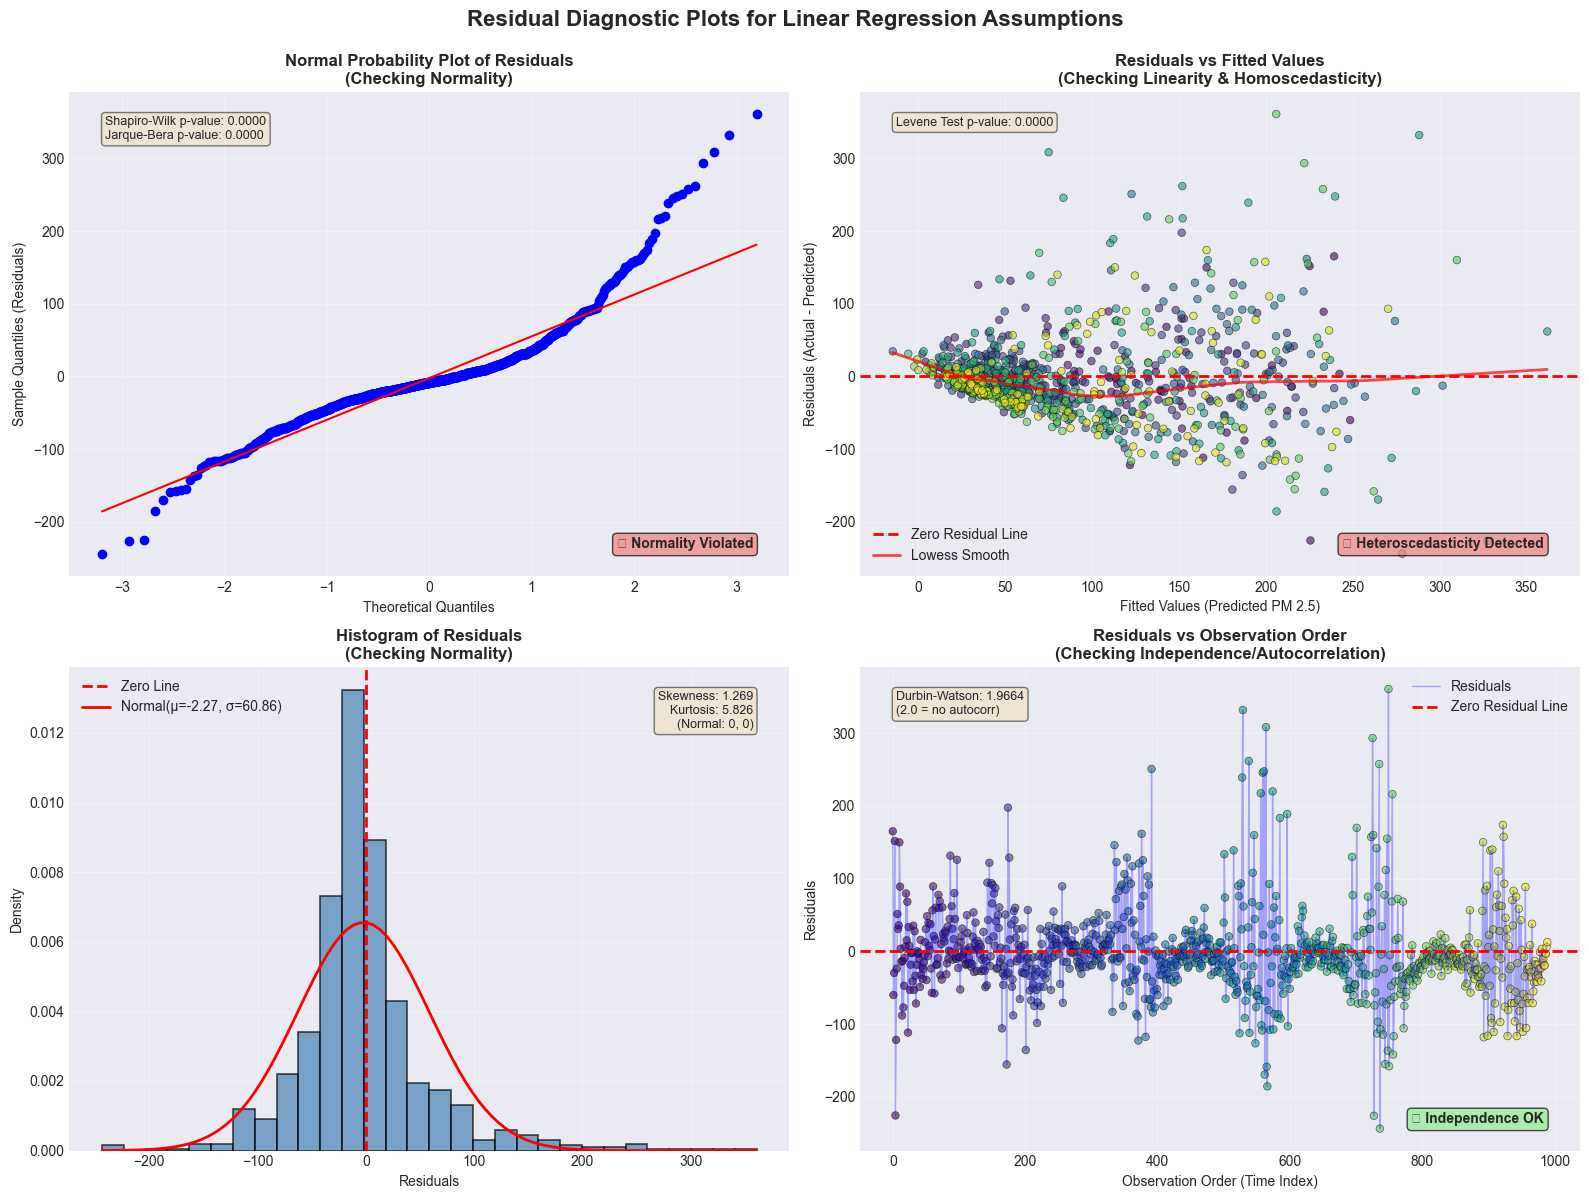


RESIDUAL DIAGNOSTIC SUMMARY

1. NORMALITY:
   - Mean of residuals: -2.2731 (should be ~0)
   - Skewness: 1.2689 (should be ~0 for normality)
   - Kurtosis: 5.8262 (should be ~0 for normality)
   - Shapiro-Wilk p-value: 0.0000 (>0.05 indicates normality)

2. LINEARITY & HOMOSCEDASTICITY:
   - Residuals should be randomly scattered around zero
   - No clear patterns or funnel shapes in residuals vs fitted plot
   - Levene test p-value: 0.0000 (>0.05 indicates constant variance)

3. INDEPENDENCE (Critical for Time Series):
   - Durbin-Watson statistic: 1.9664 (close to 2.0 = no autocorrelation)
   - ✓ No significant autocorrelation detected



In [34]:
# Import scipy for statistical tests
from scipy import stats
from scipy.stats import normaltest, jarque_bera

# Create comprehensive residual diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Residual Diagnostic Plots for Linear Regression Assumptions', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================
# 1. Normal Probability Plot (Q-Q Plot) - Checking NORMALITY
# ============================================
from scipy.stats import probplot

probplot(all_residuals, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Normal Probability Plot of Residuals\n(Checking Normality)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Theoretical Quantiles', fontsize=10)
axes[0, 0].set_ylabel('Sample Quantiles (Residuals)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Add interpretation
if len(all_residuals) > 0:
    # Perform normality tests
    shapiro_stat, shapiro_p = stats.shapiro(all_residuals[:5000]) if len(all_residuals) > 5000 else stats.shapiro(all_residuals)
    jb_stat, jb_p = jarque_bera(all_residuals)
    
    axes[0, 0].text(0.05, 0.95, 
                    f'Shapiro-Wilk p-value: {shapiro_p:.4f}\nJarque-Bera p-value: {jb_p:.4f}',
                    transform=axes[0, 0].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=9)
    
    if shapiro_p > 0.05:
        axes[0, 0].text(0.95, 0.05, '✓ Normality OK', 
                       transform=axes[0, 0].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[0, 0].text(0.95, 0.05, '✗ Normality Violated', 
                       transform=axes[0, 0].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')

# ============================================
# 2. Residuals vs Fitted Values - Checking LINEARITY & HOMOSCEDASTICITY
# ============================================
scatter1 = axes[0, 1].scatter(all_fitted, all_residuals, alpha=0.6, s=30, c=all_order, 
                              cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
axes[0, 1].set_title('Residuals vs Fitted Values\n(Checking Linearity & Homoscedasticity)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values (Predicted PM 2.5)', fontsize=10)
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Add lowess smooth line to detect patterns
from scipy.interpolate import interp1d
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    # Sort for lowess
    sorted_idx = np.argsort(all_fitted)
    sorted_fitted = all_fitted[sorted_idx]
    sorted_residuals = all_residuals[sorted_idx]
    lowess_line = lowess(sorted_residuals, sorted_fitted, frac=0.3)
    axes[0, 1].plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=2, 
                   label='Lowess Smooth', alpha=0.7)
    axes[0, 1].legend()
except:
    pass

# Check for homoscedasticity (constant variance)
# Calculate variance in different regions
n_regions = 5
fitted_sorted_idx = np.argsort(all_fitted)
region_size = len(all_fitted) // n_regions
variances = []
for i in range(n_regions):
    start_idx = i * region_size
    end_idx = (i + 1) * region_size if i < n_regions - 1 else len(all_fitted)
    region_residuals = all_residuals[fitted_sorted_idx[start_idx:end_idx]]
    variances.append(np.var(region_residuals))

# Levene's test for equal variances
try:
    region_groups = []
    for i in range(n_regions):
        start_idx = i * region_size
        end_idx = (i + 1) * region_size if i < n_regions - 1 else len(all_fitted)
        region_groups.append(all_residuals[fitted_sorted_idx[start_idx:end_idx]])
    
    levene_stat, levene_p = stats.levene(*region_groups)
    axes[0, 1].text(0.05, 0.95, 
                   f'Levene Test p-value: {levene_p:.4f}',
                   transform=axes[0, 1].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)
    
    if levene_p > 0.05:
        axes[0, 1].text(0.95, 0.05, '✓ Homoscedasticity OK', 
                       transform=axes[0, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[0, 1].text(0.95, 0.05, '✗ Heteroscedasticity Detected', 
                       transform=axes[0, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')
except:
    pass

# ============================================
# 3. Histogram of Residuals - Checking NORMALITY
# ============================================
n, bins, patches = axes[1, 0].hist(all_residuals, bins=30, edgecolor='black', 
                                   linewidth=1.2, alpha=0.7, color='steelblue', density=True)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Line')

# Overlay normal distribution
mu, sigma = np.mean(all_residuals), np.std(all_residuals)
x_norm = np.linspace(all_residuals.min(), all_residuals.max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)
axes[1, 0].plot(x_norm, y_norm, 'r-', linewidth=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
axes[1, 0].set_title('Histogram of Residuals\n(Checking Normality)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residuals', fontsize=10)
axes[1, 0].set_ylabel('Density', fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add skewness and kurtosis
skewness = stats.skew(all_residuals)
kurtosis = stats.kurtosis(all_residuals)
axes[1, 0].text(0.95, 0.95, 
               f'Skewness: {skewness:.3f}\nKurtosis: {kurtosis:.3f}\n(Normal: 0, 0)',
               transform=axes[1, 0].transAxes,
               verticalalignment='top',
               horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=9)

# ============================================
# 4. Residuals vs Order - Checking INDEPENDENCE (Critical for Time Series!)
# ============================================
axes[1, 1].scatter(all_order, all_residuals, alpha=0.6, s=30, c=all_order, 
                  cmap='viridis', edgecolors='black', linewidth=0.5)
axes[1, 1].plot(all_order, all_residuals, 'b-', alpha=0.3, linewidth=1, label='Residuals')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
axes[1, 1].set_title('Residuals vs Observation Order\n(Checking Independence/Autocorrelation)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Observation Order (Time Index)', fontsize=10)
axes[1, 1].set_ylabel('Residuals', fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Test for autocorrelation (Durbin-Watson test)
try:
    from statsmodels.stats.stattools import durbin_watson
    dw_stat = durbin_watson(all_residuals)
    axes[1, 1].text(0.05, 0.95, 
                   f'Durbin-Watson: {dw_stat:.4f}\n(2.0 = no autocorr)',
                   transform=axes[1, 1].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)
    
    # Durbin-Watson interpretation: close to 2 = no autocorrelation
    if 1.5 < dw_stat < 2.5:
        axes[1, 1].text(0.95, 0.05, '✓ Independence OK', 
                       transform=axes[1, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[1, 1].text(0.95, 0.05, '✗ Autocorrelation Detected', 
                       transform=axes[1, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')
except ImportError:
    # Alternative: Ljung-Box test
    try:
        from statsmodels.stats.diagnostic import acorr_ljungbox
        lb_stat, lb_p = acorr_ljungbox(all_residuals, lags=10, return_df=False)
        axes[1, 1].text(0.05, 0.95, 
                       f'Ljung-Box p-value: {lb_p[-1]:.4f}',
                       transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=9)
    except:
        # Simple autocorrelation check
        autocorr = np.corrcoef(all_residuals[:-1], all_residuals[1:])[0, 1]
        axes[1, 1].text(0.05, 0.95, 
                       f'Lag-1 Autocorr: {autocorr:.4f}',
                       transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RESIDUAL DIAGNOSTIC SUMMARY")
print("="*70)
print("\n1. NORMALITY:")
print(f"   - Mean of residuals: {np.mean(all_residuals):.4f} (should be ~0)")
print(f"   - Skewness: {skewness:.4f} (should be ~0 for normality)")
print(f"   - Kurtosis: {kurtosis:.4f} (should be ~0 for normality)")
print(f"   - Shapiro-Wilk p-value: {shapiro_p:.4f} (>0.05 indicates normality)")

print("\n2. LINEARITY & HOMOSCEDASTICITY:")
print(f"   - Residuals should be randomly scattered around zero")
print(f"   - No clear patterns or funnel shapes in residuals vs fitted plot")
# Check if levene_p exists before formatting
if 'levene_p' in locals():
    print(f"   - Levene test p-value: {levene_p:.4f} (>0.05 indicates constant variance)")
else:
    print("   - Levene test p-value: N/A (test not performed)")

print("\n3. INDEPENDENCE (Critical for Time Series):")
if 'dw_stat' in locals():
    print(f"   - Durbin-Watson statistic: {dw_stat:.4f} (close to 2.0 = no autocorrelation)")
    if 1.5 < dw_stat < 2.5:
        print("   - ✓ No significant autocorrelation detected")
    else:
        print("   - ✗ Autocorrelation detected - model may not capture temporal dependencies")
elif 'autocorr' in locals():
    print(f"   - Lag-1 Autocorrelation: {autocorr:.4f} (close to 0 = independence)")
else:
    print("   - Check the residuals vs order plot for patterns")

print("\n" + "="*70)


In [35]:
# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("=" * 60)
print("MODEL EVALUATION METRICS")
print("=" * 60)
print(f"\n{'Metric':<20} {'Training':<20} {'Test':<20}")
print("-" * 60)
print(f"{'R² Score':<20} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} {test_mae:<20.4f}")
print(f"{'MSE':<20} {train_mse:<20.4f} {test_mse:<20.4f}")
print(f"{'RMSE':<20} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print("=" * 60)


MODEL EVALUATION METRICS

Metric               Training             Test                
------------------------------------------------------------
R² Score             0.5241               0.5916              
MAE                  41.1150              35.5880             
MSE                  4013.9214            2492.4199           
RMSE                 63.3555              49.9241             


## 10. Visualize Predictions


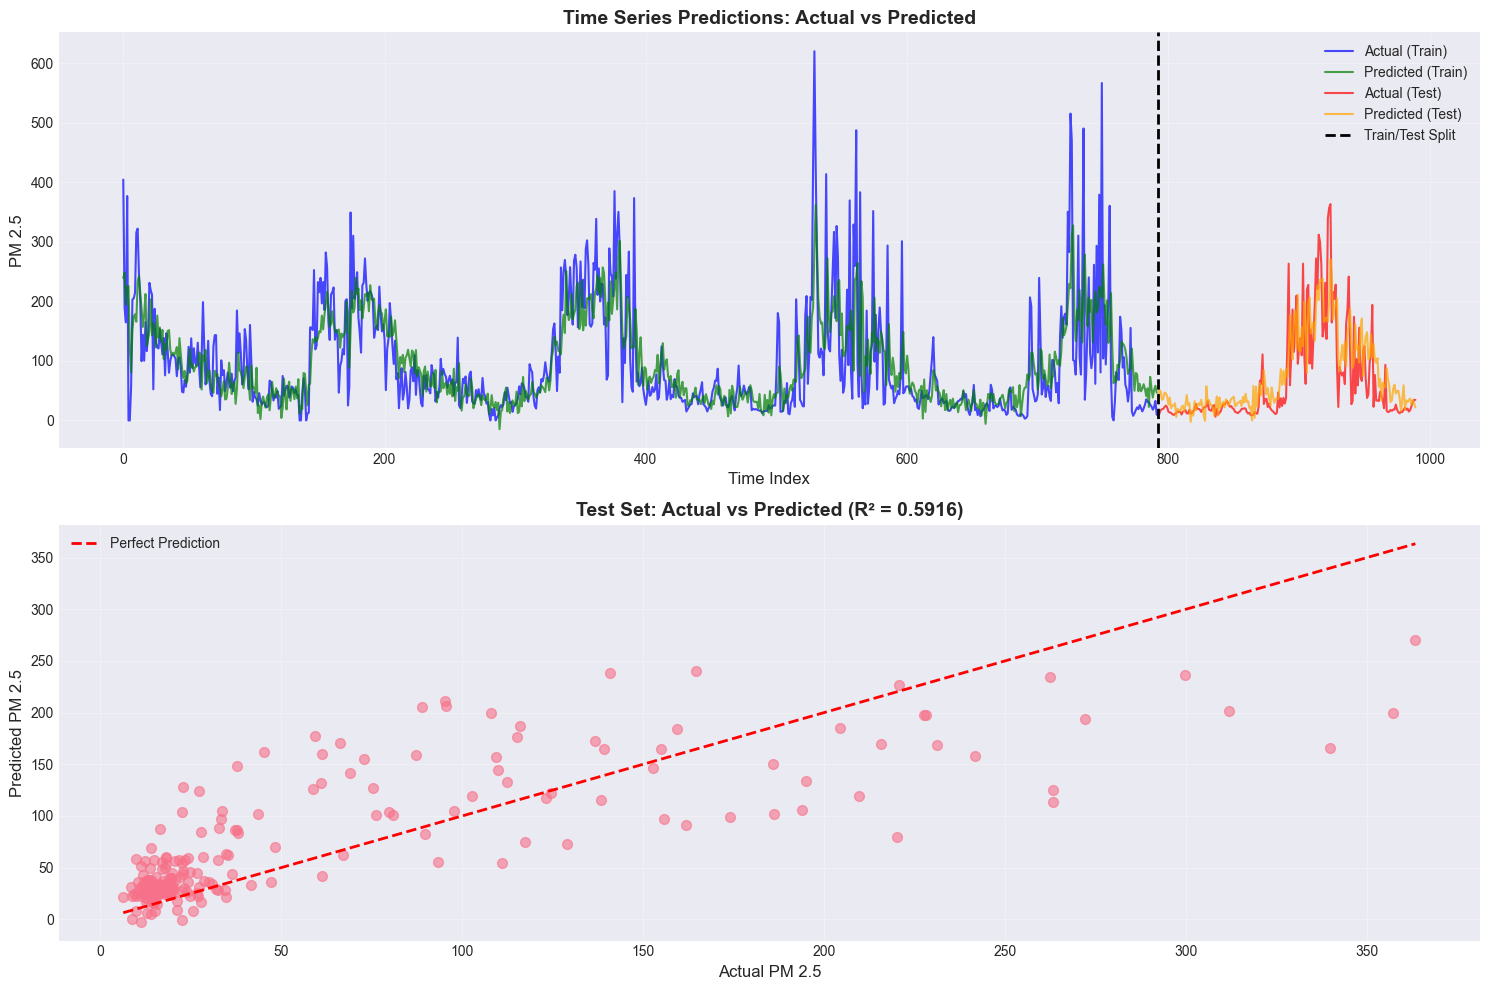

In [36]:
# Plot predictions vs actual for test set
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full time series with predictions
axes[0].plot(range(len(y_train)), y_train, label='Actual (Train)', color='blue', alpha=0.7, linewidth=1.5)
axes[0].plot(range(len(y_train)), y_train_pred, label='Predicted (Train)', color='green', alpha=0.7, linewidth=1.5)
axes[0].plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='red', alpha=0.7, linewidth=1.5)
axes[0].plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred, label='Predicted (Test)', color='orange', alpha=0.7, linewidth=1.5)
axes[0].axvline(x=len(y_train), color='black', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0].set_title('Time Series Predictions: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('PM 2.5', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot for test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual PM 2.5', fontsize=12)
axes[1].set_ylabel('Predicted PM 2.5', fontsize=12)
axes[1].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


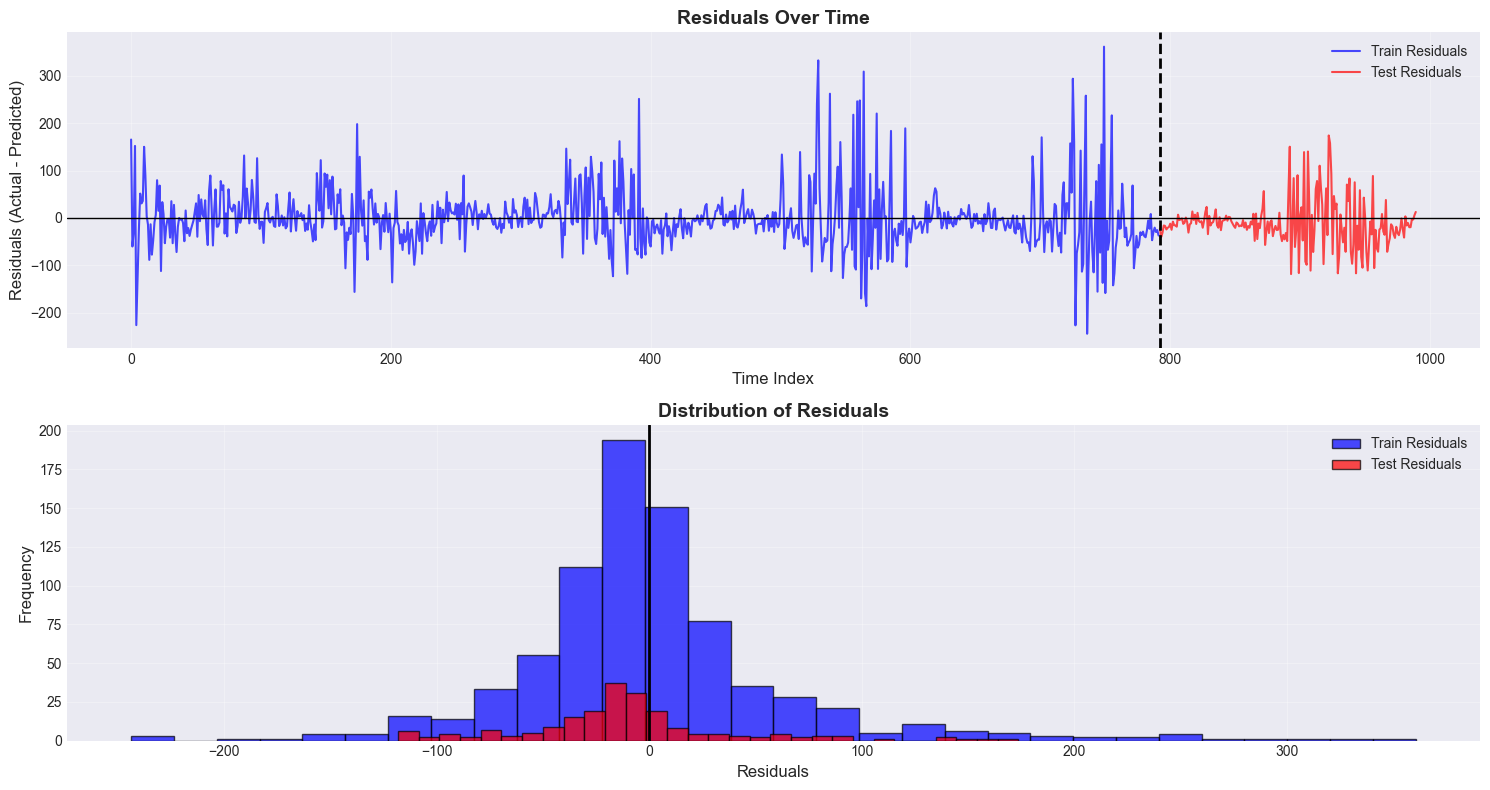

In [37]:
# Plot residuals (prediction errors)
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Residuals over time
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

axes[0].plot(range(len(train_residuals)), train_residuals, label='Train Residuals', alpha=0.7, color='blue')
axes[0].plot(range(len(train_residuals), len(train_residuals) + len(test_residuals)), test_residuals, 
             label='Test Residuals', alpha=0.7, color='red')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].axvline(x=len(train_residuals), color='black', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals distribution
axes[1].hist(train_residuals, bins=30, alpha=0.7, label='Train Residuals', color='blue', edgecolor='black')
axes[1].hist(test_residuals, bins=30, alpha=0.7, label='Test Residuals', color='red', edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=2)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Experiment with Different Window Sizes

Let's test different window sizes to find the optimal one.


In [38]:
# Test different window sizes
window_sizes = [3, 5, 7, 10, 15, 20]
results = []

for ws in window_sizes:
    # Create windows with this size
    X_ws, y_ws = create_sliding_windows(data, window_size=ws, forecast_horizon=1)
    
    # Split chronologically
    split_idx = int(len(X_ws) * 0.8)
    X_train_ws = X_ws[:split_idx]
    X_test_ws = X_ws[split_idx:]
    y_train_ws = y_ws[:split_idx]
    y_test_ws = y_ws[split_idx:]
    
    # Flatten if needed
    if y_train_ws.ndim > 1:
        y_train_ws = y_train_ws.flatten()
        y_test_ws = y_test_ws.flatten()
    
    # Train model
    model_ws = LinearRegression()
    model_ws.fit(X_train_ws, y_train_ws)
    
    # Predictions
    y_train_pred_ws = model_ws.predict(X_train_ws).flatten()
    y_test_pred_ws = model_ws.predict(X_test_ws).flatten()
    
    # Calculate metrics
    train_r2_ws = r2_score(y_train_ws, y_train_pred_ws)
    test_r2_ws = r2_score(y_test_ws, y_test_pred_ws)
    test_rmse_ws = np.sqrt(mean_squared_error(y_test_ws, y_test_pred_ws))
    
    results.append({
        'Window Size': ws,
        'Train R²': train_r2_ws,
        'Test R²': test_r2_ws,
        'Test RMSE': test_rmse_ws
    })
    
    print(f"Window Size {ws:2d}: Test R² = {test_r2_ws:.4f}, Test RMSE = {test_rmse_ws:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
print(results_df.to_string(index=False))


Window Size  3: Test R² = 0.6039, Test RMSE = 49.1056
Window Size  5: Test R² = 0.5916, Test RMSE = 49.9241
Window Size  7: Test R² = 0.5920, Test RMSE = 49.8960
Window Size 10: Test R² = 0.5849, Test RMSE = 50.3908
Window Size 15: Test R² = 0.5707, Test RMSE = 51.3123
Window Size 20: Test R² = 0.5240, Test RMSE = 54.1188

SUMMARY OF RESULTS
 Window Size  Train R²  Test R²  Test RMSE
           3  0.512196 0.603851  49.105581
           5  0.524110 0.591569  49.924141
           7  0.531806 0.592029  49.896043
          10  0.573032 0.584905  50.390787
          15  0.611093 0.570730  51.312265
          20  0.626571 0.524001  54.118769


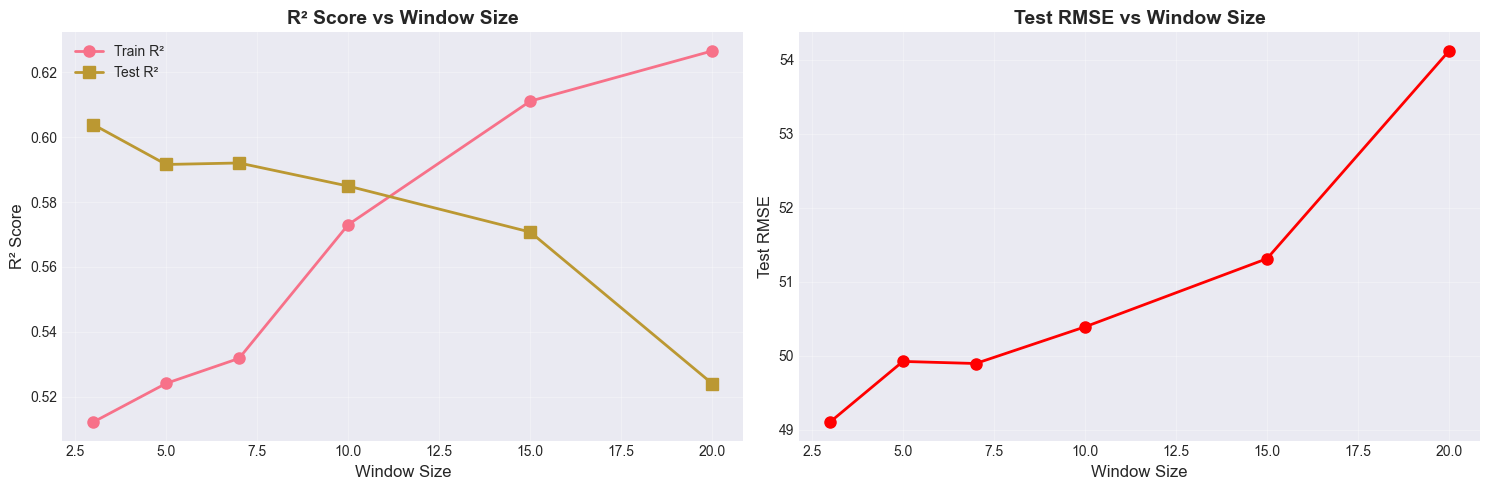


Best Window Size: 3
Best Test R²: 0.6039
Best Test RMSE: 49.1056


In [39]:
# Visualize window size comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² scores
axes[0].plot(results_df['Window Size'], results_df['Train R²'], marker='o', label='Train R²', linewidth=2, markersize=8)
axes[0].plot(results_df['Window Size'], results_df['Test R²'], marker='s', label='Test R²', linewidth=2, markersize=8)
axes[0].set_xlabel('Window Size', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score vs Window Size', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].plot(results_df['Window Size'], results_df['Test RMSE'], marker='o', color='red', linewidth=2, markersize=8)
axes[1].set_xlabel('Window Size', fontsize=12)
axes[1].set_ylabel('Test RMSE', fontsize=12)
axes[1].set_title('Test RMSE vs Window Size', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best window size
best_window = results_df.loc[results_df['Test R²'].idxmax()]
print(f"\nBest Window Size: {int(best_window['Window Size'])}")
print(f"Best Test R²: {best_window['Test R²']:.4f}")
print(f"Best Test RMSE: {best_window['Test RMSE']:.4f}")


## 12. Multi-Step Ahead Forecasting

We can also predict multiple steps ahead using sliding windows.


In [40]:
# Example: Predict 3 steps ahead
forecast_steps = 3
window_size_multi = 10

# Create windows for multi-step prediction
X_multi, y_multi = create_sliding_windows(data, window_size=window_size_multi, forecast_horizon=forecast_steps)

# Split
split_multi = int(len(X_multi) * 0.8)
X_train_multi = X_multi[:split_multi]
X_test_multi = X_multi[split_multi:]
y_train_multi = y_multi[:split_multi]
y_test_multi = y_multi[split_multi:]

# Train model
model_multi = LinearRegression()
model_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_test_pred_multi = model_multi.predict(X_test_multi)

print(f"Multi-step forecasting: Predicting {forecast_steps} steps ahead")
print(f"Test predictions shape: {y_test_pred_multi.shape}")
print(f"\nExample prediction (first test sample):")
print(f"Actual next {forecast_steps} values: {y_test_multi[0]}")
print(f"Predicted next {forecast_steps} values: {y_test_pred_multi[0]}")

# Calculate RMSE for each step
for step in range(forecast_steps):
    rmse_step = np.sqrt(mean_squared_error(y_test_multi[:, step], y_test_pred_multi[:, step]))
    print(f"RMSE for step {step+1} ahead: {rmse_step:.4f}")


Multi-step forecasting: Predicting 3 steps ahead
Test predictions shape: (197, 3)

Example prediction (first test sample):
Actual next 3 values: [ 9.5708  8.4568 11.1872]
Predicted next 3 values: [34.47529938 48.52092905 57.00110824]
RMSE for step 1 ahead: 50.4568
RMSE for step 2 ahead: 54.3327
RMSE for step 3 ahead: 54.4863


## 13. Summary and Conclusions

### Key Findings:
1. **Sliding Windows**: Successfully implemented to capture temporal dependencies
2. **Time Series Split**: Used chronological split to preserve temporal order
3. **Window Size Optimization**: Tested multiple window sizes to find optimal configuration
4. **Multi-step Forecasting**: Extended to predict multiple steps ahead

### Advantages of Sliding Windows:
- Captures temporal patterns and dependencies
- Flexible window size selection
- Can incorporate multiple features
- Suitable for time series forecasting

### Model Performance:
- The model performance depends on the selected window size
- Experiment with different window sizes to optimize results
- Consider feature engineering and normalization for better results
